# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

### Obiettivo

L'obiettivo è di aumentare il numero di contatti a clienti aventi esito positivo, ovvero la sottoscrizione della polizza. 


Il report illustra le fasi del processo di creazione del modello predittivo:
- Raccolta dei dati
- Esplorazione dei dati
- Preparazione dei dati
- Creazione del modello predittivo
- Interpretazione dei risultati 

Il modello predittivo utilizzato in questo studio è la regressione logistica. 

I risultati del modello indicano che la variabile più importante nella predizione dell'acquisto dell'assicurazione per il veicolo è il tipo di assicurazione sanitaria posseduta dal cliente. 

Il report conclude con alcune raccomandazioni per migliorare il modello e aumentare l'accuratezza delle previsioni.



In [171]:
# import library
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [172]:
import warnings
warnings.filterwarnings('ignore')

# Global Parameter
BASE_path = "./dataset/"

# Plot setting
plt.rcParams["figure.figsize"]= (8,5)
plt.style.use('bmh')
#sns.set_theme()

RANDOM_SEED=0

### Raccolta dei dati

Per questo studio è stato utilizzato il dataset **"Health Insurance Cross Sell Prediction"** disponibile e pronto all'uso su [Kaggle.com](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/code).

Il dataset contiene informazioni sui dati demografici (sesso, età, tipo di codice regionale), veicoli (età del veicolo, danni), polizza (premio, canale di approvvigionamento) ed è composto dalle seguenti proprietà:

| Feature | Description |
| ------- | ----------- |
| **id:** | id univoco dell'acquirente.|
| **Gender:** | sesso dell'acquirente.|
| **Age:** | età dell'acquirente.|
| **Driving_License:** | 1 se l'utente ha la patente di guida, 0 altrimenti.|
| **Region_Code:** | codice univoco della regione dell'acquirente.|
| **Previously_Insured:** | 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.|
| **Vehicle_Age:** | età del veicolo|
| **Vehicle_Damage:** | 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.|
| **Annual_Premium:** | la cifra che l'utente deve pagare come premio durante l'anno.|
| **Policy_Sales_Channel:** | codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)|
| **Vintage:** | numero di giorni dalla quale l'utente è cliente dell'azienda.|
| **Response:** | 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.|




Il dataset è costituito da un archivio zip (`archive.zip`) estratto nella directory `dataset`:

```
 ├── FondametiML_FinalProject.ipynb
 ├── dataset
     ├── train.csv
     ├── test.csv
     ├── sample_submission.csv
```


In [173]:
# import dataset
df = pd.read_csv(BASE_path+"train.csv")

### Esplorazione dei Dati - EDA (Exploratory Data Analysis)

Inzio con l'esplorazione dei dati al fine di comprenderne meglio la struttura e mettere in evidenza eventuali relazioni. 

In [174]:
print(f"Dataset Dimension: {df.shape}")
df.head()


Dataset Dimension: (381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


#### Preprocessing

Elimino la feature '**id**' che non apporta alcuna informazione, e applico il laber encoding alle variabili categorali

In [175]:
df = df.drop(["id"], axis=1)

per applicare il label encoding alle colonne con valori stringa, vado a vedere il range di labels e creo la mappatura

In [176]:
print(df["Gender"].value_counts())
print("---")
print(df["Vehicle_Age"].value_counts())
print("---")
print(df["Vehicle_Damage"].value_counts())

Male      206089
Female    175020
Name: Gender, dtype: int64
---
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64
---
Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64


| Gender    |   | Vehicle_Damage |   | Vehicle_Age  |
| --------: | -  | :------------: | - | :----------: |
| Male: 1   |   | Yes: 1         |   | < 1 Year : 0 |
| Female : 0|   | No : 0         |   | 1-2 Year : 1 |
|           |   |                |   | > 2 Years: 2 |

In [177]:
# label Encoding
Gender_map = {"Female":0, "Male":1}
df["Gender"]=df["Gender"].map(Gender_map)

Vehicle_Damage_map = {"No":0, "Yes":1}
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(Vehicle_Damage_map)

Vehicle_Age_map = {"< 1 Year":0, "1-2 Year":1, "> 2 Years":2}
df["Vehicle_Age"]=df["Vehicle_Age"].map(Vehicle_Age_map)

df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [178]:
df.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,38.822584,0.997869,26.388807,0.458210,0.609616,0.504877,30564.389581,112.034295,154.347397,0.122563
std,0.498336,15.511611,0.046110,13.229888,0.498251,0.567439,0.499977,17213.155057,54.203995,83.671304,0.327936
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,1.000000,36.000000,1.000000,28.000000,0.000000,1.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Da una prima analisi puramente descrittiva possiamo osservare che:
- **Age:** l'età degli assicurati è compresa tra i 20 e gli 80 anni, ma la maggior parte (il 75%) ha un'età inferiore ai 49 anni.
- **Annual_Premium:** ha una ditribuzione tra un minimo di 2630 \$ e un massimo di 540165 \$, sebbene la maggior parte degli assicurati (~75%) paga un premio inferiore a 40000$
- **Vintage:** il tempo di permanenza medio è di 154 giorni, nessuna osservazione raggiunge l'anno di permanenza. Sarebbe utile capire se questo dato di riferisce ad una permanenza assoluta (e quindi capire perchè la compagnia non riesce a trattenere il cliente) oppure è una permanenza relativa agli attuali clienti e quindi il dato è influenzata da altri fattori (ad es. la data di inzio condservazione del dato).
- **Response:** è evidente che il set è fortemente sbilanciato verso la classe negativa (Response=0)

In [179]:
# duplicate ?
print(f" Numero Osservazioni duplicate: {df.duplicated().sum()} - {100*df.duplicated().sum()/df.shape[0]:.2f}% del dataset \n")
print(f" ... di cui con esito positivo:  {df[df.duplicated()]['Response'].sum()} - {100*df[df.duplicated()]['Response'].sum()/df.duplicated().sum():.2f}% ({100*df[df.duplicated()]['Response'].sum()/df.shape[0]:.2f}% del dataset) \n")

# info - nan value ?
df.info()

 Numero Osservazioni duplicate: 269 - 0.07% del dataset 

 ... di cui con esito positivo:  25 - 9.29% (0.01% del dataset) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 32.0 MB


Il dataset non contiene valori nulli 

#### Variabili

Vado a vedere la correlazione delle variabili calcolando la matrice di correlazione

<AxesSubplot:>

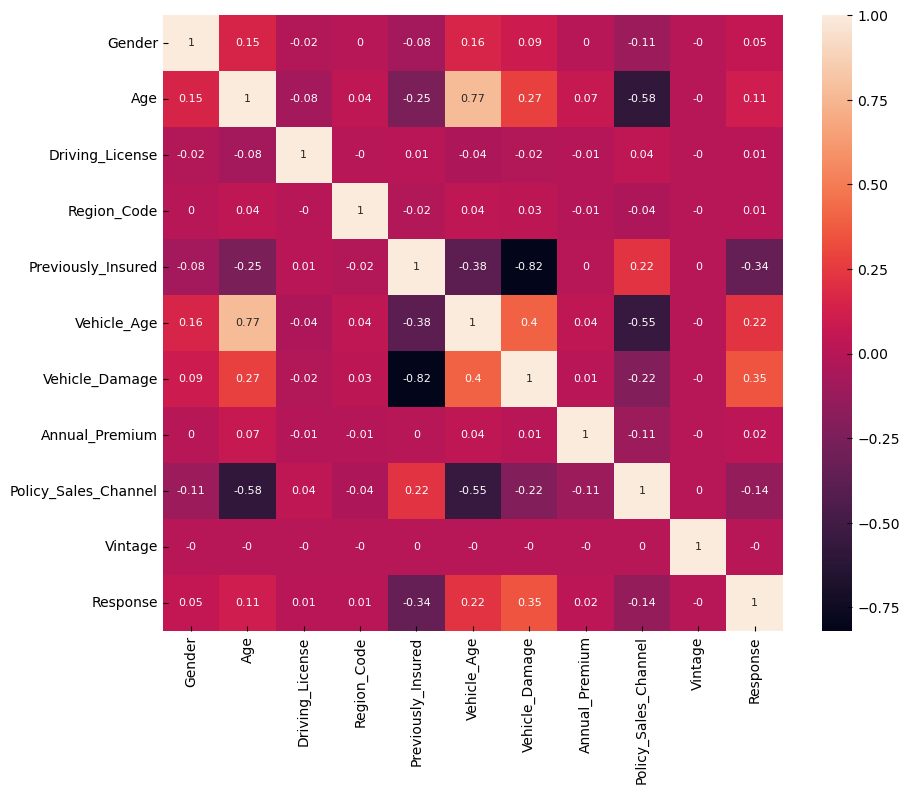

In [180]:
plt.rcParams["figure.figsize"]= (10,8)
sns.heatmap(df.corr().round(2), annot=True, annot_kws={"size":8})

La matrice di correlazione non mostra nessuna correlazione forte tra variabile e target.

E' presente una correlazione tra le variabili `Age` e `Veihcle_Age` (0.77) e una correlazione inversa tra le variabili `Vehicle_Damage` e `Previously_Insured` (0.82).

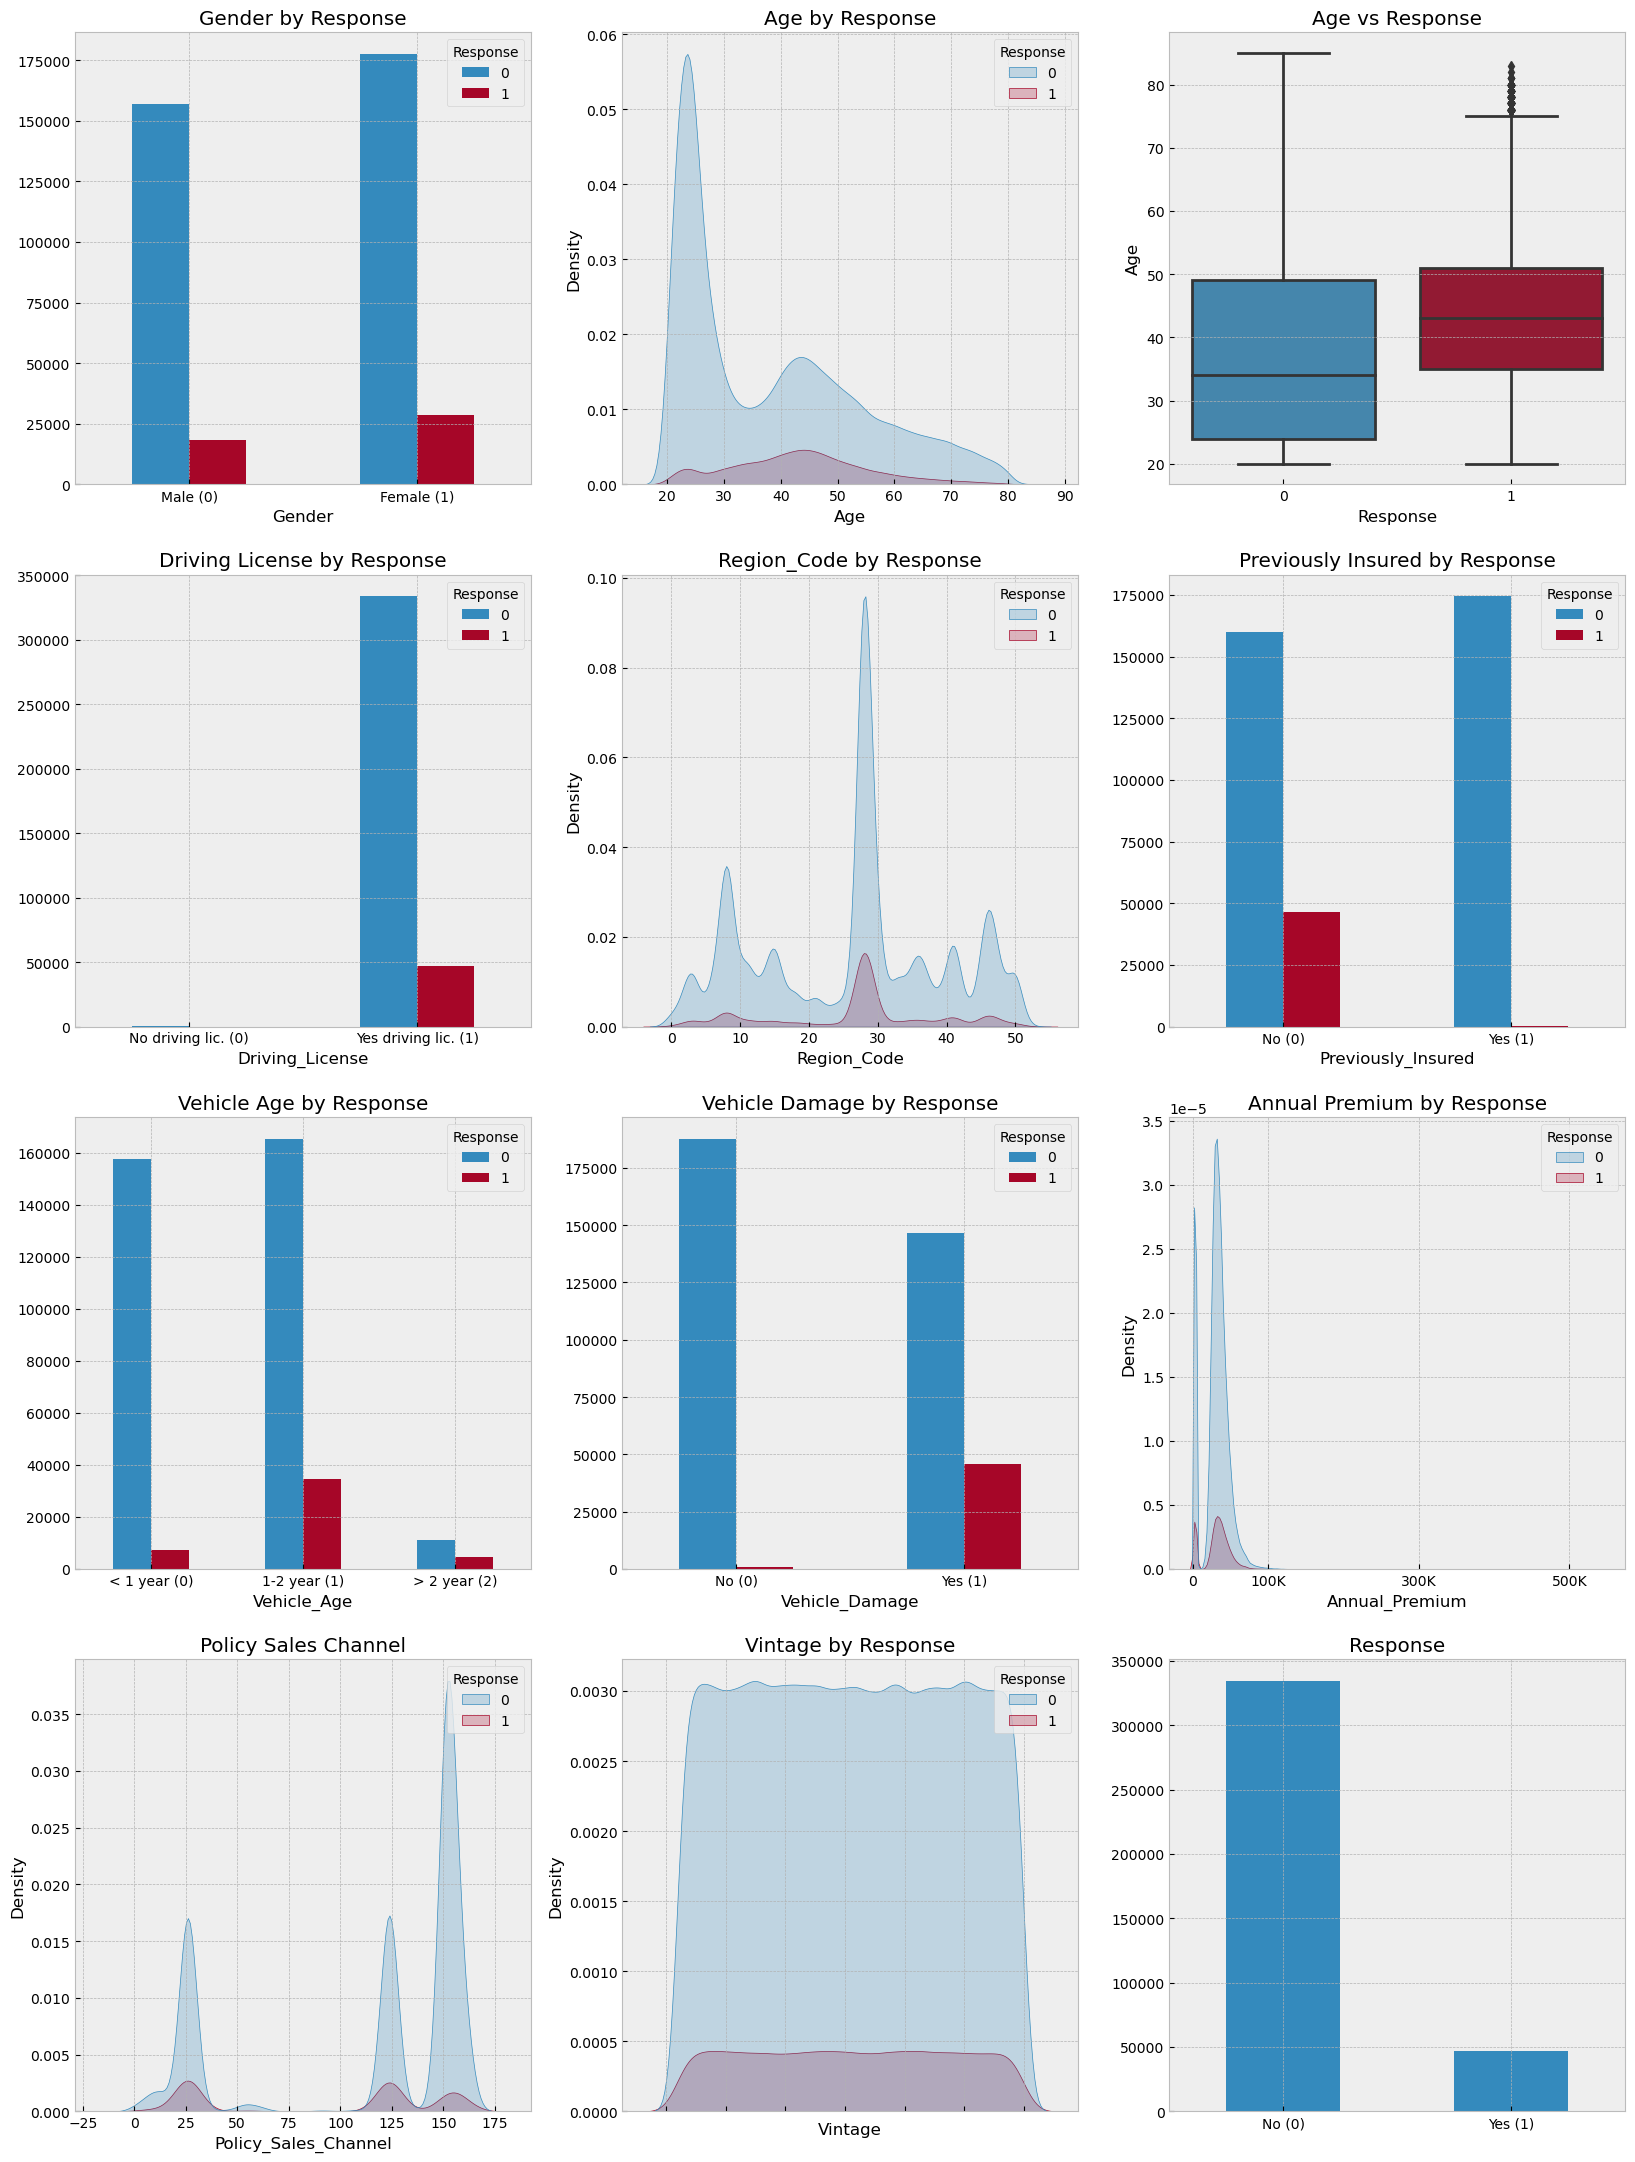

In [181]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20,27))

# plot 1 
df.groupby(["Gender","Response"]).size().unstack(fill_value=0).plot(kind="bar", ax=axs[0,0])
axs[0,0].set_title('Gender by Response')
axs[0,0].set_xticklabels(["Male (0)", "Female (1)"])

# plot 2
sns.kdeplot(x='Age', hue='Response', shade=True, data=df, ax=axs[0,1])
axs[0,1].set_title('Age by Response')

#plot 3
sns.boxplot(x="Response", y="Age", data=df, ax=axs[0,2])
axs[0,2].set_title('Age vs Response')

# plot 4
df.groupby(["Driving_License", "Response"]).size().unstack(fill_value=0).plot(kind="bar", ax=axs[1,0])
axs[1,0].set_title('Driving License by Response')
axs[1,0].set_xticklabels(["No driving lic. (0)", "Yes driving lic. (1)"])

#plot 5
sns.kdeplot(x='Region_Code', hue='Response',  shade=True, data=df, ax=axs[1,1])
axs[1,1].set_title('Region_Code by Response')

# plot 6
df.groupby(["Previously_Insured", "Response"]).size().unstack(fill_value=0).plot(kind="bar", ax=axs[1,2])
axs[1,2].set_title('Previously Insured by Response')
axs[1,2].set_xticklabels(["No (0)", "Yes (1)"])

# plot 7
df.groupby(["Vehicle_Age", "Response"]).size().unstack(fill_value=0).plot(kind="bar", ax=axs[2,0])
axs[2,0].set_title('Vehicle Age by Response')
axs[2,0].set_xticklabels(["< 1 year (0)", "1-2 year (1)", "> 2 year (2)"])

# plot 8
df.groupby(["Vehicle_Damage", "Response"]).size().unstack(fill_value=0).plot(kind="bar", ax=axs[2,1])
axs[2,1].set_title('Vehicle Damage by Response')
axs[2,1].set_xticklabels(["No (0)", "Yes (1)"])

# plot 9
sns.kdeplot(x='Annual_Premium', hue='Response', shade=True, data=df, ax=axs[2,2])
axs[2,2].set_title('Annual Premium by Response')
axs[2,2].set_xticks((0,100000,300000,500000))
axs[2,2].set_xticklabels(('0','100K','300K','500K'), rotation=0)

# plot 10
sns.kdeplot(x='Policy_Sales_Channel', hue='Response', shade=True, data=df, ax=axs[3,0])
axs[3,0].set_title('Policy Sales Channel')

# plot 11
sns.kdeplot(x='Vintage', hue='Response', shade=True, data=df, ax=axs[3,1])
axs[3,1].set_title('Vintage by Response')


# plot 12
df["Response"].value_counts().plot(kind="bar", ax=axs[3,2])
axs[3,2].set_title('Response', )
axs[3,2].set_xticklabels(["No (0)", "Yes (1)"])

axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=0)
#axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=0)
axs[0,2].set_xticklabels(axs[0,2].get_xticklabels(), rotation=0)
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=0)
#axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=0)
axs[1,2].set_xticklabels(axs[1,2].get_xticklabels(), rotation=0)
axs[2,0].set_xticklabels(axs[2,0].get_xticklabels(), rotation=0)
axs[2,1].set_xticklabels(axs[2,1].get_xticklabels(), rotation=0)
#axs[2,2].set_xticklabels(axs[2,2].get_xticklabels(), rotation=0)
axs[3,1].set_xticklabels(axs[3,1].get_xticklabels(), rotation=0)

axs[3,2].set_xticklabels(axs[3,2].get_xticklabels(), rotation=0)

plt.show()

Come anticipato, è evidente che il dataset sia fortemente sbilanciato verso la classe negativa, che conta oltre l'87% del totale.

In [182]:
counts = df["Response"].value_counts()
print(f"Negative Response (0) : {100*counts[0]/counts.sum():.2f}%")
print(f"Positive Response (1) : {100*counts[1]/counts.sum():.2f}%")

Negative Response (0) : 87.74%
Positive Response (1) : 12.26%


Non si osserva uno sbilanciamento in base al genere:

In [183]:
counts = df.groupby(["Gender","Response"]).size()
print(f"Female (0) : {100*counts[0].sum()/counts.sum():.2f}% (Negative: {100*counts[0][0]/counts[0].sum():.2f}%, Positive: {100*counts[0][1]/counts[0].sum():.2f}%)")
print(f"  Male (1) : {100*counts[1].sum()/counts.sum():.2f}% (Negative: {100*counts[1][0]/counts[1].sum():.2f}%, Positive: {100*counts[1][1]/counts[1].sum():.2f}%)")

Female (0) : 45.92% (Negative: 89.61%, Positive: 10.39%)
  Male (1) : 54.08% (Negative: 86.16%, Positive: 13.84%)


La quasi totalità del campione è in possesso di patente di guida (`Driving_License`).

E' presente una maggior propensione all'acquisto di un'assicurazione:

- nella fascia di età tra i 40 e 50 anni rispetto gli under 30 (`Age`).
- i possessori di un veicolo di almeno 1 anno, aumentando per chi supera i 2 anni (`Veihcle_Age`).
- chi ha subito danni in precedenza (`Veihcle_Damage`)




**Da una prima analisi possiamo assumere che il tasso di successo sia poco superiore al 10%** : su 10 contatti estratti casualmente soltanto 1 porterà all'esito positivo (stipula del contratto di assicurazione).





## Creazione del Modello Predittivo - Regressione Logistica (Classificazione Binaria)

### Definisco alcune funzioni utili

In [184]:
# creo la funzione per la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=False, ax=None, title=None):

    cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp

    df_cm = pd.DataFrame(cm,
                         index = ["True Negative", "True Positive"],
                         columns = ["Predicted "+labels[0], "Predicted "+labels[1]],
                         )
    plt.rcParams["figure.figsize"]= (8,5)
    sns.heatmap(df_cm, annot=True, fmt="g",ax=ax)

    if show_precision_recall:
        ax.set_title(f"{title}:   Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}   -   Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}", fontsize=9)



# definisco una funzione per avere un report del dataset
def info_dataset(x, y, label=""):

    print("----------")
    counts=y.value_counts()
    print(f"{label} Dataset: {x.shape} - {y.shape}")
    print(counts)
    print(f"Negative Response (0) : {100*counts[0]/counts.sum():.2f}%")
    print(f"Positive Response (1) : {100*counts[1]/counts.sum():.2f}%")
 

### Divido il dataset in feature e target

Inizio con fare dei test su tutte le feature , eccetto l'id che ho già scartato all'inizio.

Poi proverò ad applicare il modello su un dataset dove andrò a droppare alcune feature non influenti (come mostra la matrice di correlazione).

In [185]:
# separo feature e target
X = df.drop(["Response"], axis=1)
Y = df["Response"]

# dimensioni
#print(X.shape, Y.shape)

# percentuale response - starting point
counts = Y.value_counts()
#print(counts)
print("-------------")
print(f"Negative Response (0) : {100*counts[0]/counts.sum():.2f}%")
print(f"Positive Response (1) : {100*counts[1]/counts.sum():.2f}%")

-------------
Negative Response (0) : 87.74%
Positive Response (1) : 12.26%


1 su 10 contatti ha esito positivo

### Divido il dataset in train/test set

Questi set verranno usati negli step successivi.

In [186]:
# train and test sets
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=.3, random_state=RANDOM_SEED)

print(f"Train Dataset: {X_TRAIN.shape} - {Y_TRAIN.shape}")
print(f"Test Dataset : {X_TEST.shape} - {Y_TEST.shape}")

Train Dataset: (266776, 10) - (266776,)
Test Dataset : (114333, 10) - (114333,)


### Modello di Regressione Logistica

é un problema di classificazione.

Ho già visto che il dataset è fortemente sbilanciato verso la classe negativa, quindi applicherò alcune strategia per bilanciare il trein set. 


Valuto un primo modello senza bilanciamento (No Balanced) e successivamente applicherò alcune strategie (Balanced).

preparo il dataset, applico la standardizzazione alle sole variabili numeriche.

In [187]:
# effettuo copie del dataset originale
X_train = X_TRAIN.copy()
y_train = Y_TRAIN.copy()
X_test = X_TEST.copy()
y_test = Y_TEST.copy()

# standardizzazione delle variabili numeriche/continue
cont_features = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

ss = StandardScaler()
X_train[cont_features] = ss.fit_transform(X_train[cont_features])
X_test[cont_features] = ss.transform(X_test[cont_features])



#### Logistic Regression - No Balanced (Baseline)

In [188]:
# logistic regressione senza bilanciamento
lr = LogisticRegression(random_state=RANDOM_SEED) 
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

##### Valutazione del Modello - LR No balnced

In [189]:
# calcolo le previsioni e le probabilità
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    234158
           1       0.36      0.00      0.00     32618

    accuracy                           0.88    266776
   macro avg       0.62      0.50      0.47    266776
weighted avg       0.81      0.88      0.82    266776


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100241
           1       0.44      0.00      0.00     14092

    accuracy                           0.88    114333
   macro avg       0.66      0.50      0.47    114333
weighted avg       0.82      0.88      0.82    114333



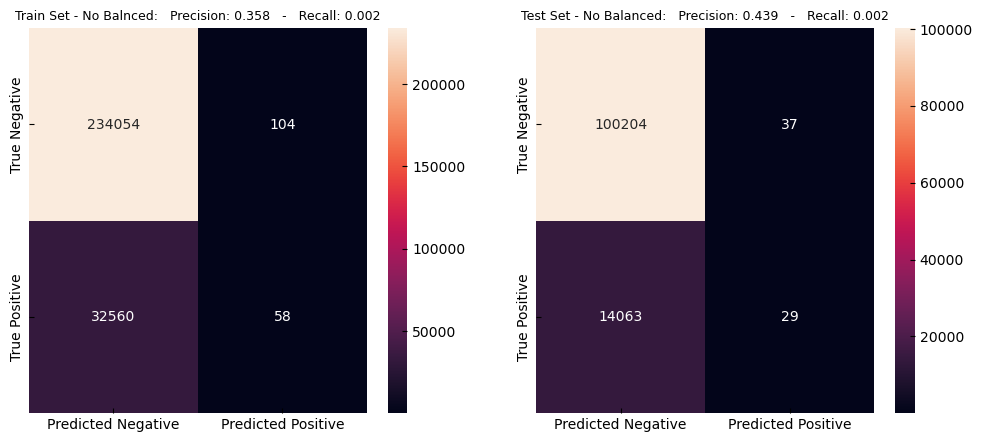

In [190]:
print("CLASSIFICATION REPORT-------------------------m(°.°)m")

print("\n........................................... TRAIN SET")
print(classification_report(y_train,y_pred_train))

print("\n............................................ TEST SET")
print(classification_report(y_test,y_pred_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = "Train Set - No Balnced")
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set - No Balanced")

#### Logistic Regression - Class Balanced (strategia 1)

Imposto l'attributo `class_weight="balanced"` alla classe LogisticRegression() senza manipolare il dataset.

In [146]:
# logistic regressione con bilanciamento
lr = LogisticRegression(class_weight="balanced" ,random_state=RANDOM_SEED) 
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

##### valutazione del Modello - LR Balanced

CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234158
           1       0.25      0.98      0.40     32618

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



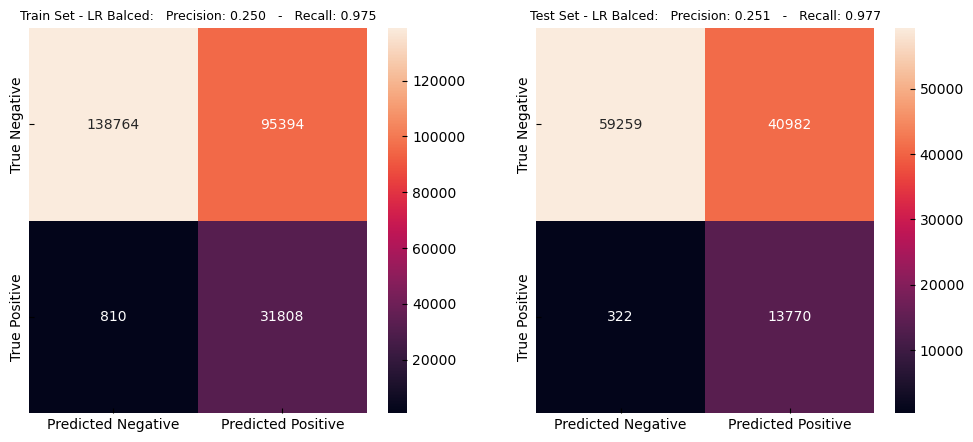

In [147]:
# calcolo le previsioni e le probabilità
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)


print("CLASSIFICATION REPORT-------------------------m(°.°)m")

print("\n........................................... TRAIN SET")
print(classification_report(y_train,y_pred_train))

print("\n............................................ TEST SET")
print(classification_report(y_test,y_pred_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = "Train Set - LR Balced")
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set - LR Balced")

E' evidente come il modello sia già migliorato sensibilmente:

|SET|Precision|Recall|Accuracy|
|:--|:-------:|:----:|:------:|
|Test Set| 0.251 | 0.977 | 0.64|


Provo ad applicare tecniche di ricampionamento (Re-Sample) per provare a migliorare il modello.

## Re-sample

Procedo con il sovracampionamento della classe minoritaria.

Il dataset è abbastanza grande, il sovracampionamento sarà eseguito solo sul train set in modo da non influenzare il test set.

In [23]:
# import libreris for unbalanced dataset
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Il dataset originale è sempre X e Y, mentre lo split è sempre X_TRAIN, X_TEST, Y_TRAIN, Y_TEST [qui](#divisione-in-traintest-set)

- Procedimento:
  1. Applico il resample (over/under) al solo train-set
  2. Applico la standardizzazione alle variabili numeriche
  3. Addestro il modello di regressione logistica
  4. Applico il modello al test set
  5. Valuto il modello

### OverSimple

In [163]:
# dataset
X_train = X_TRAIN.copy()
y_train = Y_TRAIN.copy()
X_test = X_TEST.copy()
y_test = Y_TEST.copy()

# numerical/continous feature
cont_features = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

info_dataset(X_train,y_train)

----------
 Dataset: (266776, 10) - (266776,)
0    234158
1     32618
Name: Response, dtype: int64
Negative Response (0) : 87.77%
Positive Response (1) : 12.23%


In [164]:
# define oversampling strategy
ros = RandomOverSampler(sampling_strategy="minority", random_state=RANDOM_SEED)

# fit_apply resample on ONLY train set
X_train, y_train = ros.fit_resample(X_train, y_train)

#info_dataset(X_train, y_train, "Train - OverSample")

# standardizzazione
ss = StandardScaler()
X_train[cont_features] = ss.fit_transform(X_train[cont_features])
X_test[cont_features] = ss.transform(X_test[cont_features])

info_dataset(X_train,y_train)

----------
 Dataset: (468316, 10) - (468316,)
1    234158
0    234158
Name: Response, dtype: int64
Negative Response (0) : 50.00%
Positive Response (1) : 50.00%


#### Addestro il modello sul nuovo set - oversample

In [165]:
# logistic regressione - non uso l'attributo "balanced" perchè ora il dataset è bilanciato
lr = LogisticRegression()#random_state=RANDOM_SEED)
lr.fit(X_train, y_train)

LogisticRegression()

CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    234158
           1       0.71      0.98      0.82    234158

    accuracy                           0.78    468316
   macro avg       0.83      0.78      0.78    468316
weighted avg       0.83      0.78      0.78    468316


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



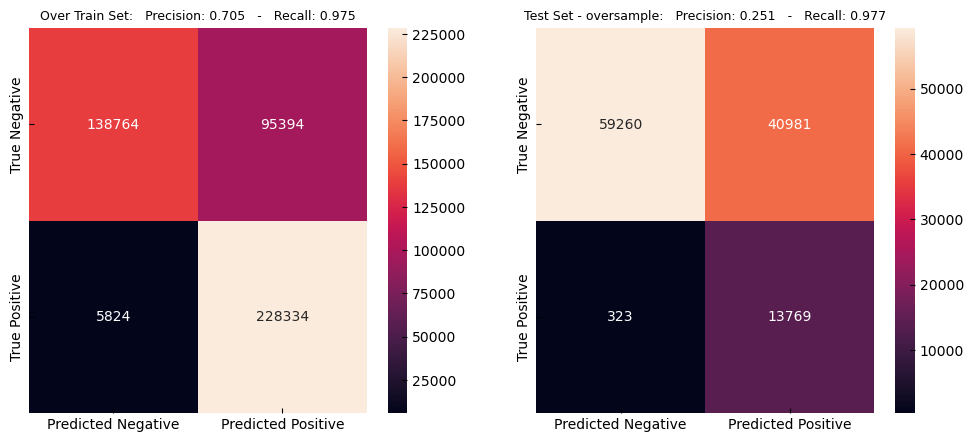

In [166]:
# valuto modello
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

print("CLASSIFICATION REPORT-------------------------m(°.°)m")

print("\n........................................... TRAIN SET")
print(classification_report(y_train,y_pred_train))

print("\n............................................ TEST SET")
print(classification_report(y_test,y_pred_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = "Over Train Set")
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set - oversample")

### UnderSample

In [167]:
# dataset
X_train = X_TRAIN.copy()
y_train = Y_TRAIN.copy()
X_test = X_TEST.copy()
y_test = Y_TEST.copy()

# numerical/continous feature
cont_features = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
#cont_features = ["Age","Annual_Premium"]

In [168]:
# Applico l'undersample alla classe maggioritaria sampling_strategy='majority'
rus = RandomUnderSampler(sampling_strategy='majority', random_state=RANDOM_SEED)

# fit_apply resample on ONLY train set
X_train, y_train = rus.fit_resample(X_TRAIN, Y_TRAIN)

# standardizzazione
ss = StandardScaler()
X_train[cont_features] = ss.fit_transform(X_train[cont_features])
X_test[cont_features] = ss.transform(X_test[cont_features])

info_dataset(X_train,y_train)

----------
 Dataset: (65236, 10) - (65236,)
0    32618
1    32618
Name: Response, dtype: int64
Negative Response (0) : 50.00%
Positive Response (1) : 50.00%


### Addestro il modello sul nuovo set 

In [169]:
# logistic Regr
lr = LogisticRegression()
lr.fit(X_train, y_train) 

LogisticRegression()

CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     32618
           1       0.71      0.97      0.82     32618

    accuracy                           0.78     65236
   macro avg       0.83      0.78      0.78     65236
weighted avg       0.83      0.78      0.78     65236


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



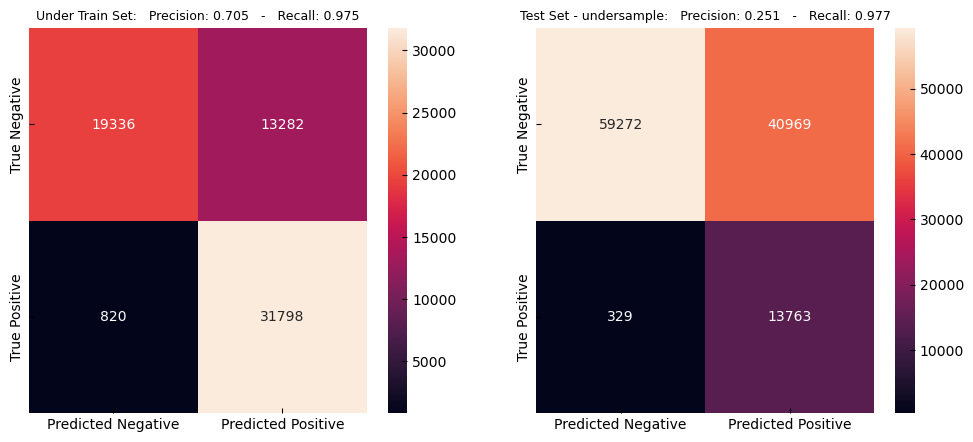

In [170]:
# valuto modello
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

print("CLASSIFICATION REPORT-------------------------m(°.°)m")

print("\n........................................... TRAIN SET")
print(classification_report(y_train,y_pred_train))

print("\n............................................ TEST SET")
print(classification_report(y_test,y_pred_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = "Under Train Set")
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set - undersample")

Anche applicando diversi valori all'attributo `sampling_strategy` sia per l'oversample che per l'undersimple (vedi sotto [ciclo for](#combining-over-sample)), il modello rimane sui valori visti sopra
| Model | Precision | Recall |  Accuracy |
|-------|----------|--------|---------|
|LR     |  0.251  |   0.977|  0.64  |  

Pertanto verrà usato il seguemnte modello:

`lr = LogisticRegression(class_weight="balanced" ,random_state=RANDOM_SEED) `



### Combining Over-Sample

over 0.2 - under 0.2
CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.84      0.99      0.91    163090
           1       0.49      0.05      0.09     32618

    accuracy                           0.83    195708
   macro avg       0.66      0.52      0.50    195708
weighted avg       0.78      0.83      0.77    195708


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    100241
           1       0.41      0.05      0.09     14092

    accuracy                           0.87    114333
   macro avg       0.65      0.52      0.51    114333
weighted avg       0.82      0.87      0.83    114333

over 0.2 - under 0.3
CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    reca

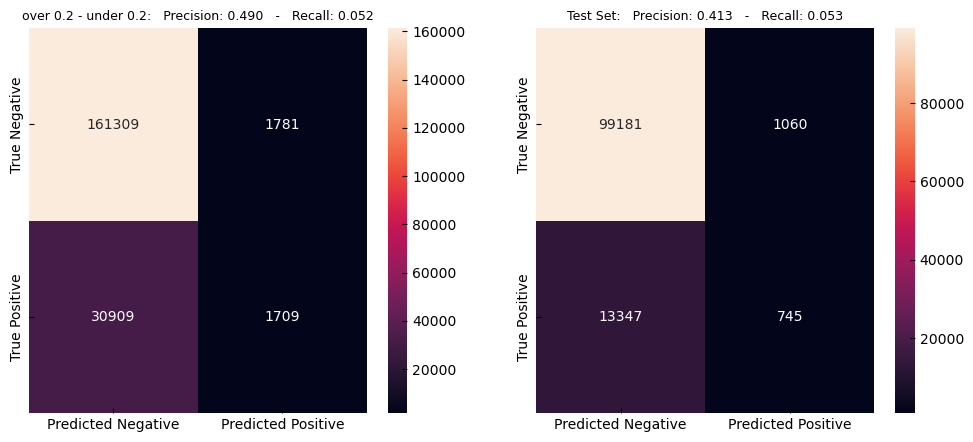

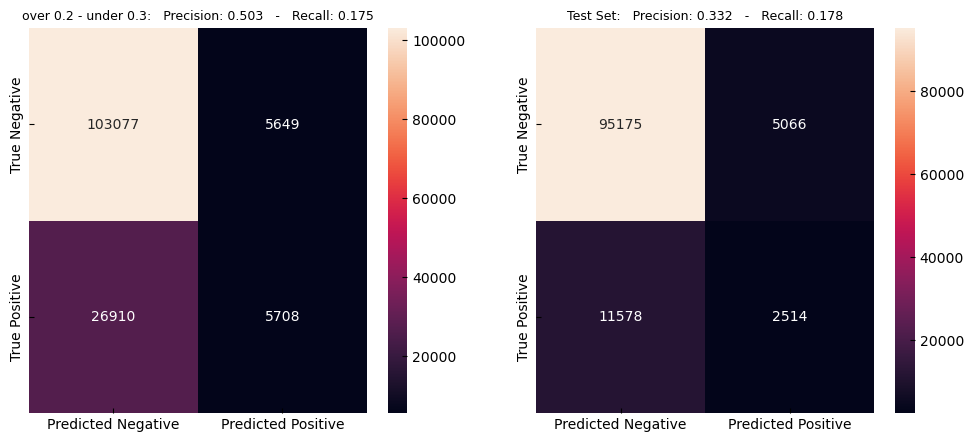

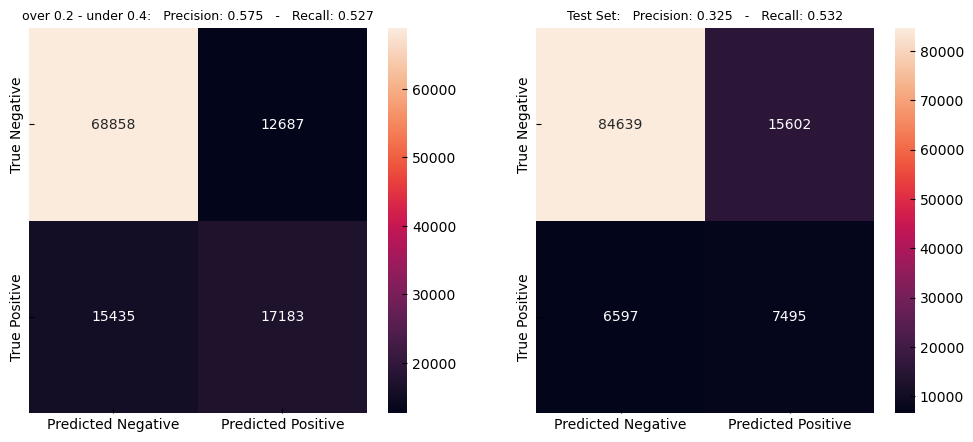

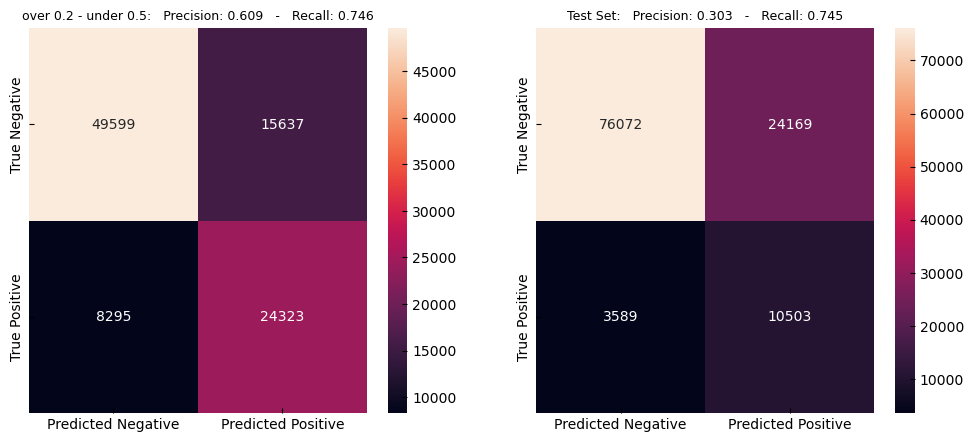

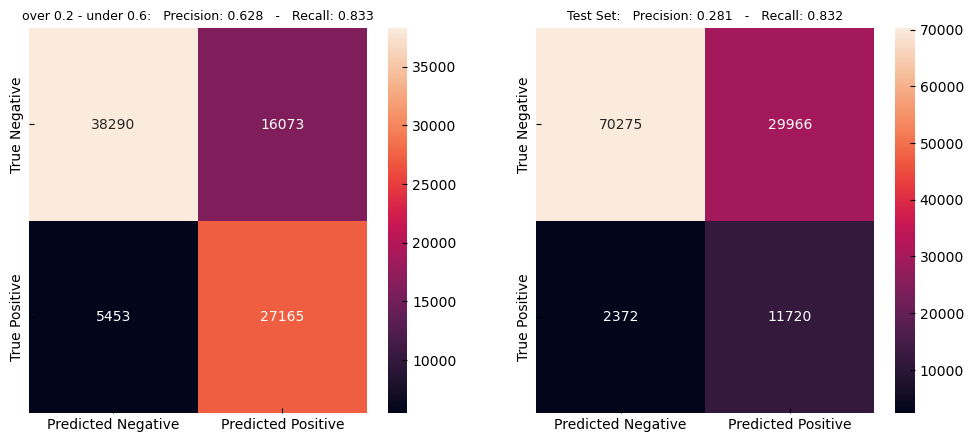

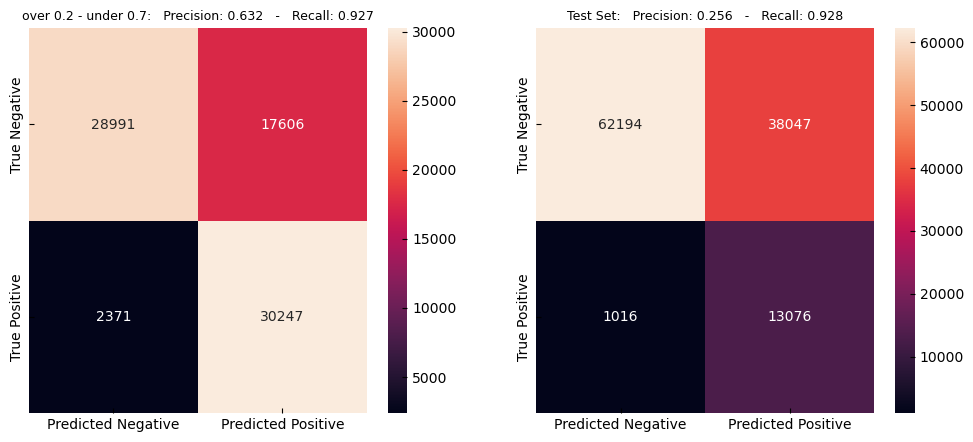

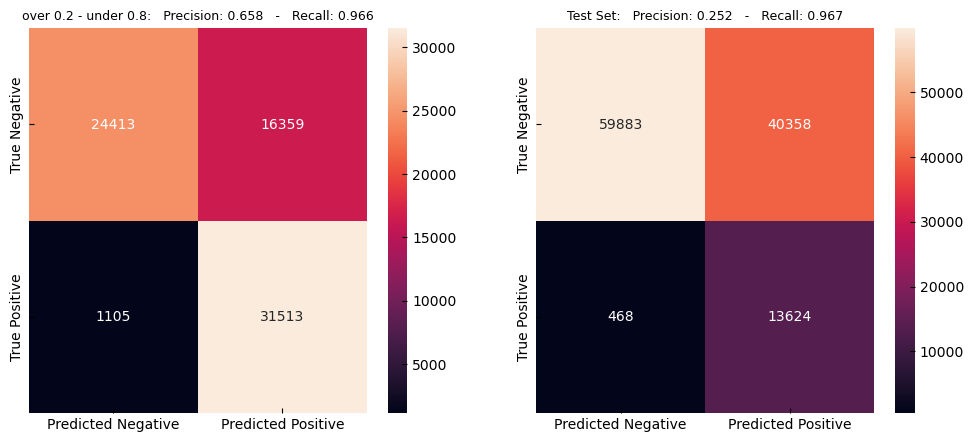

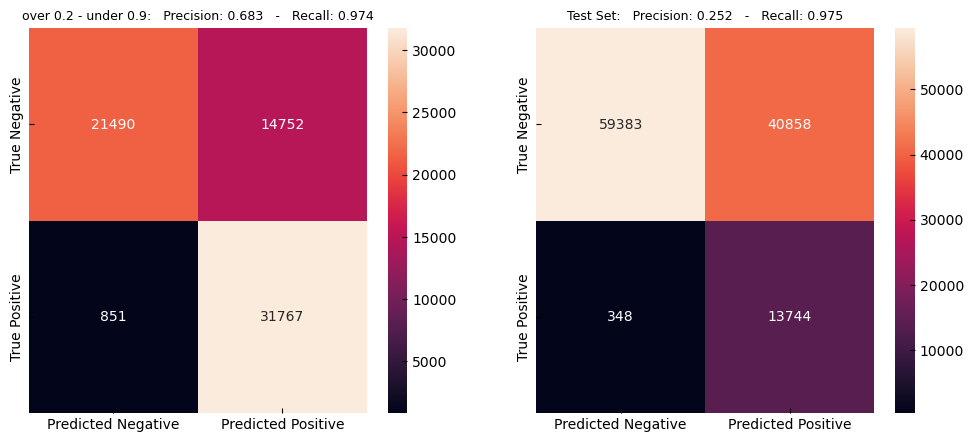

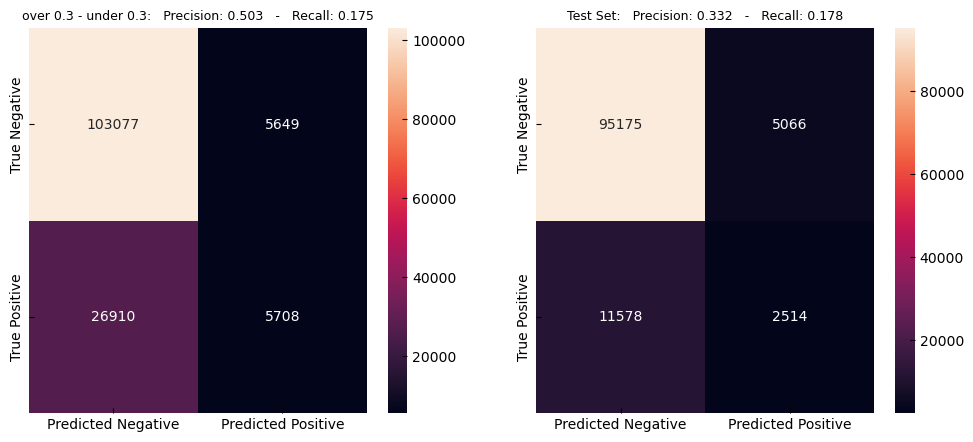

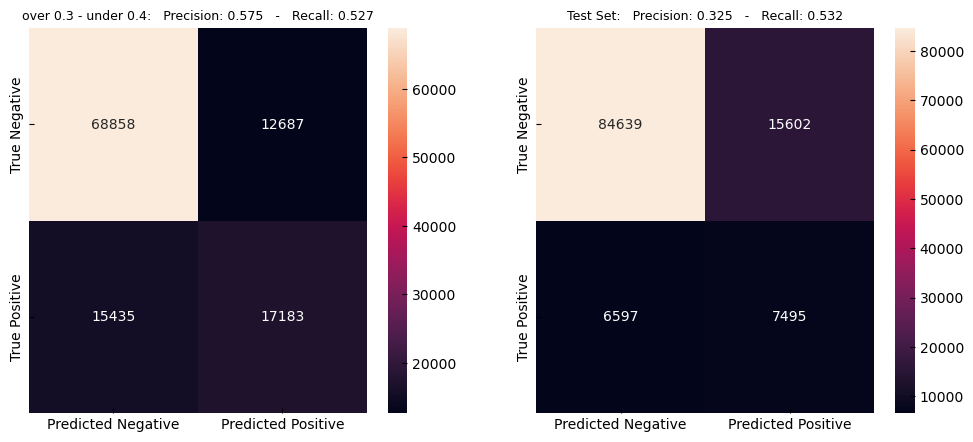

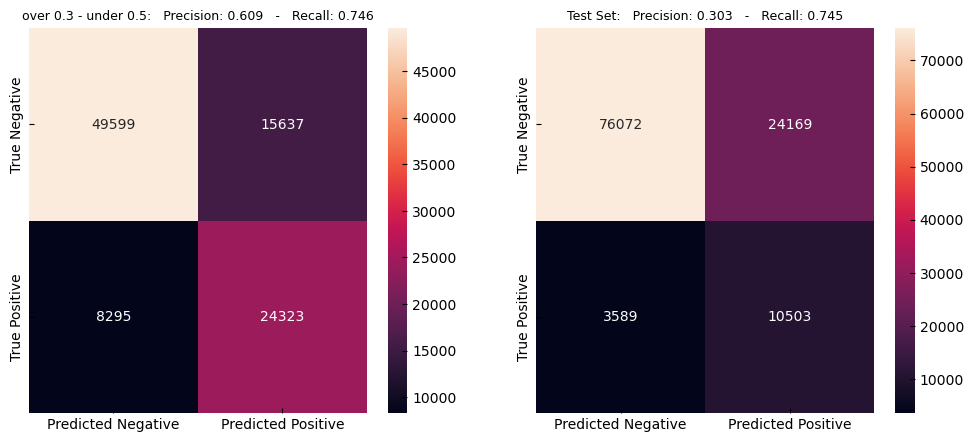

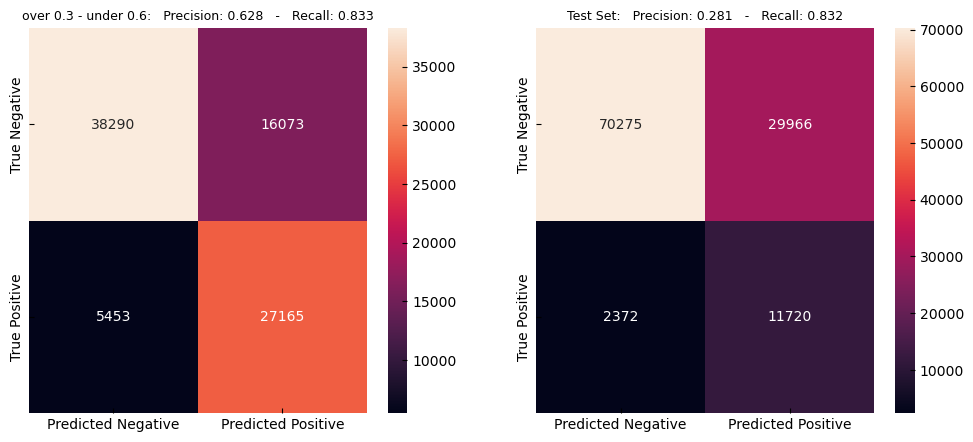

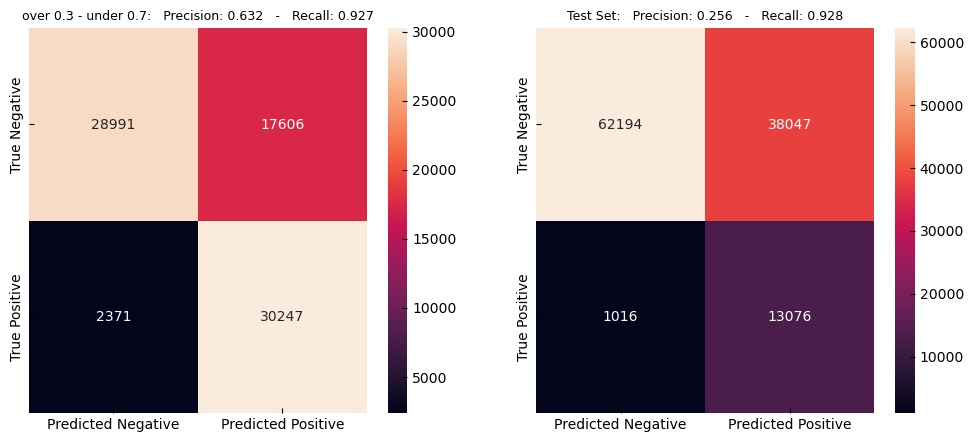

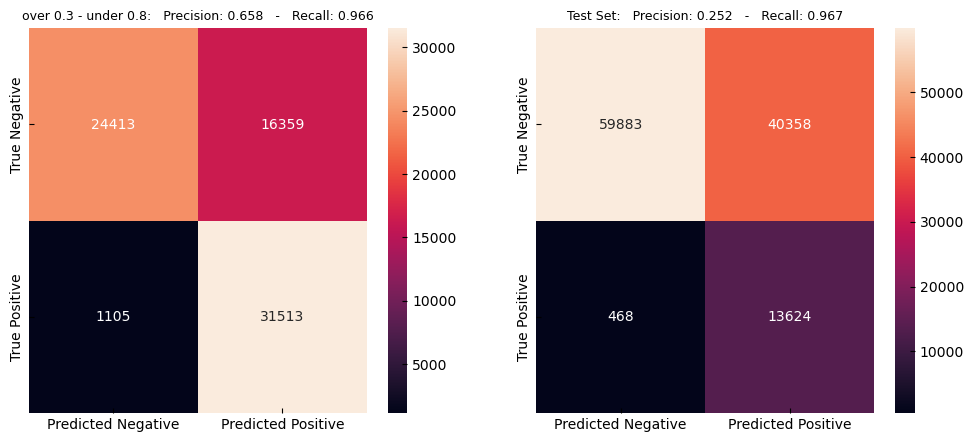

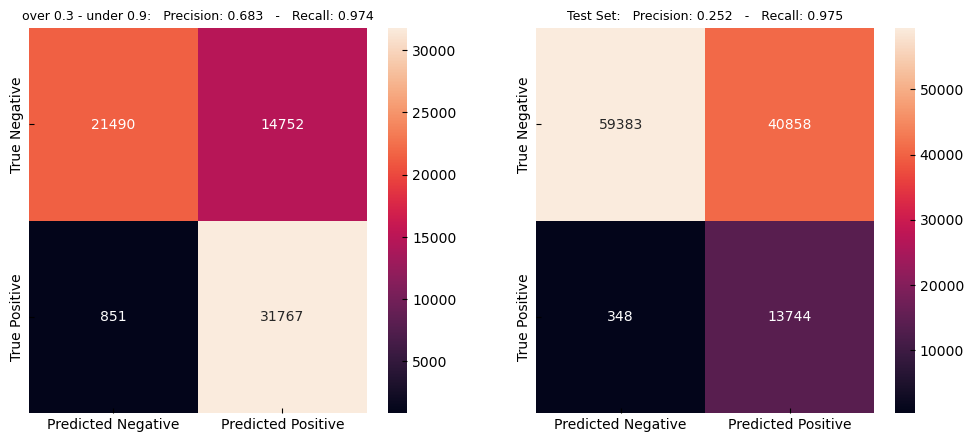

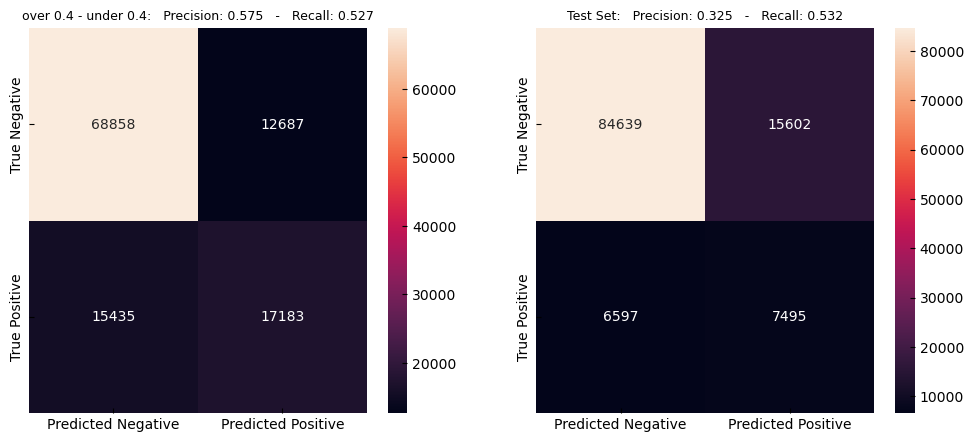

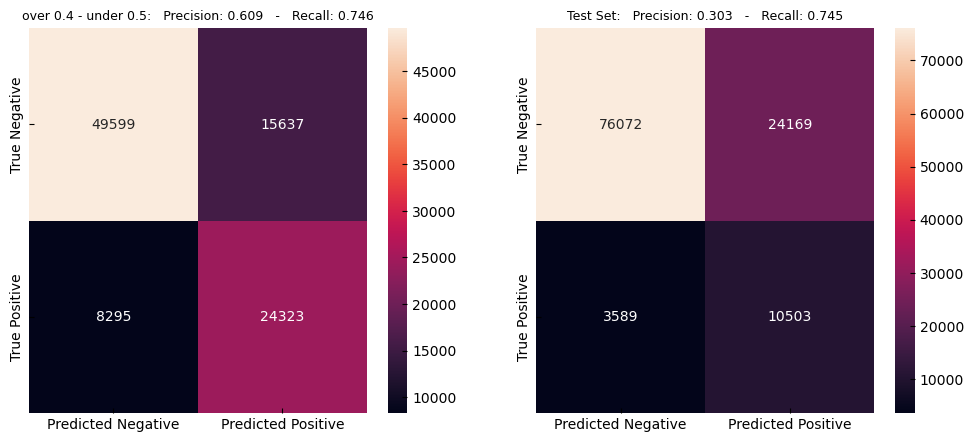

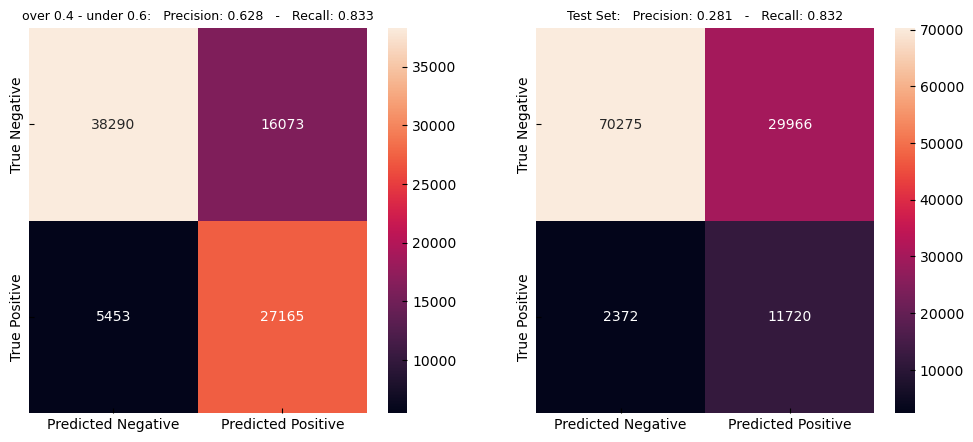

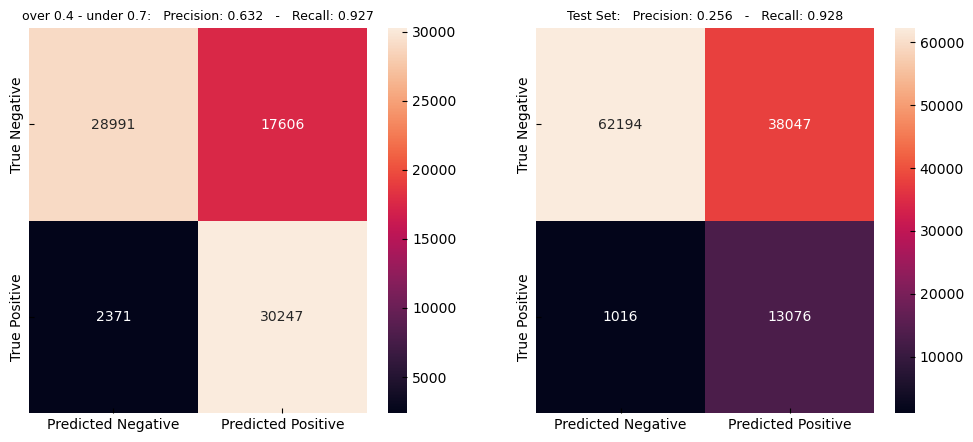

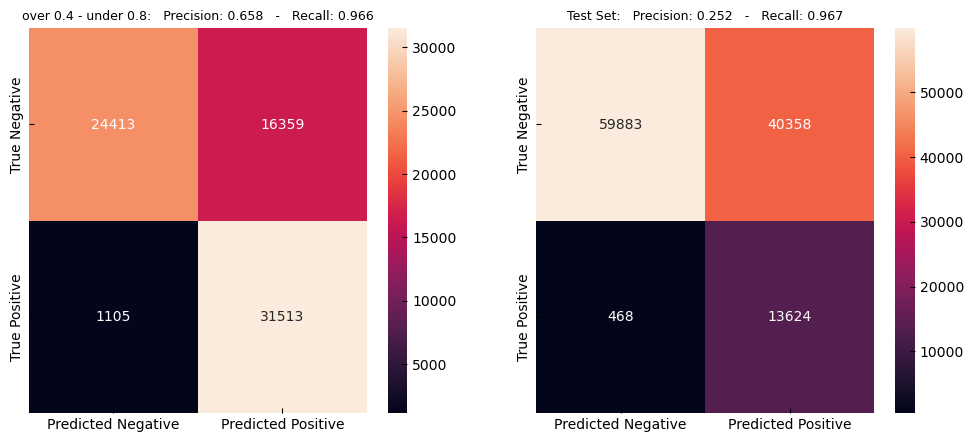

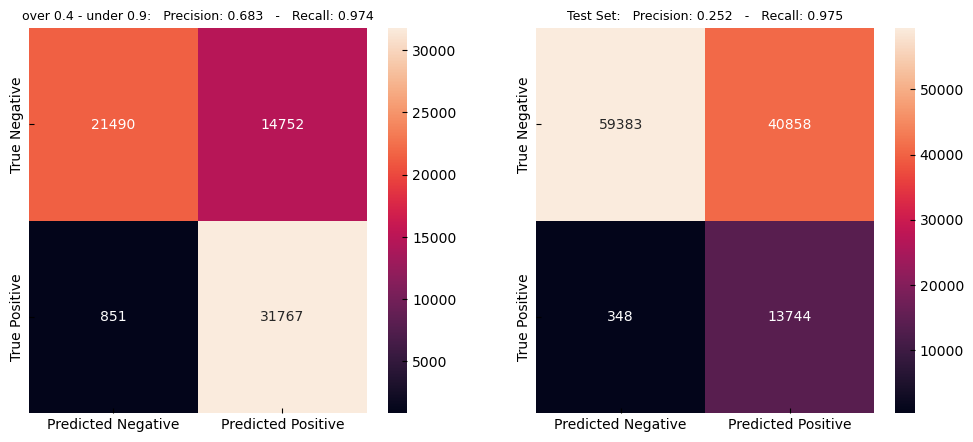

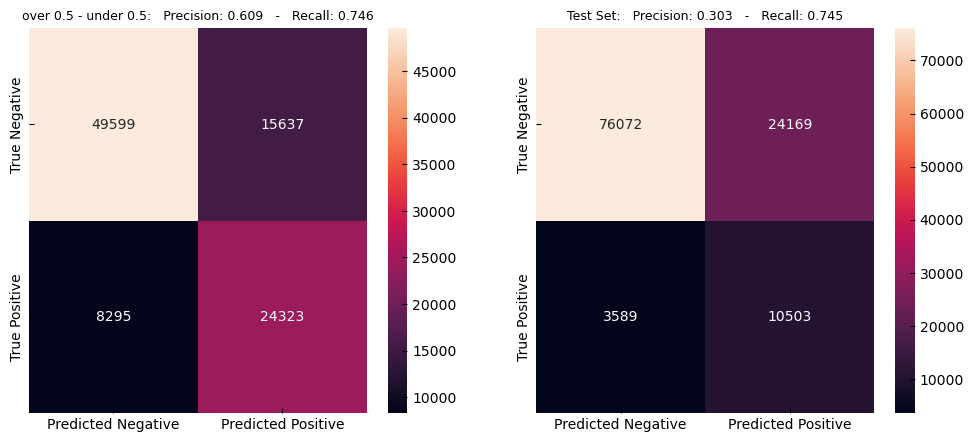

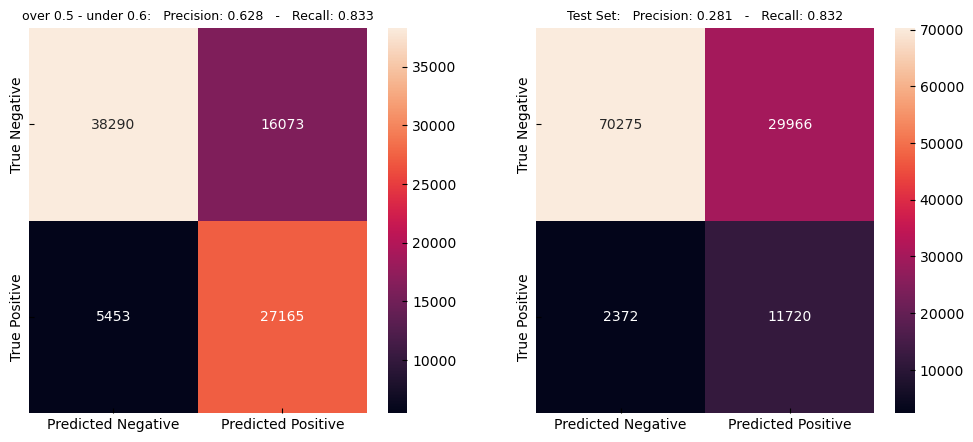

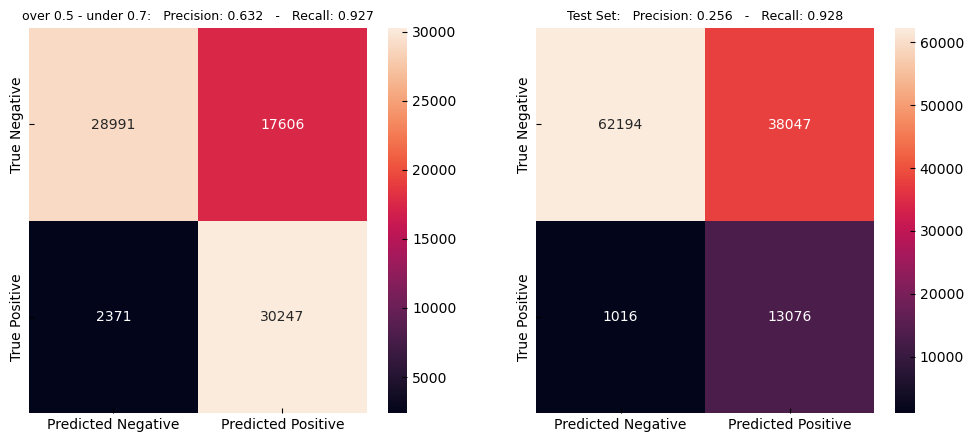

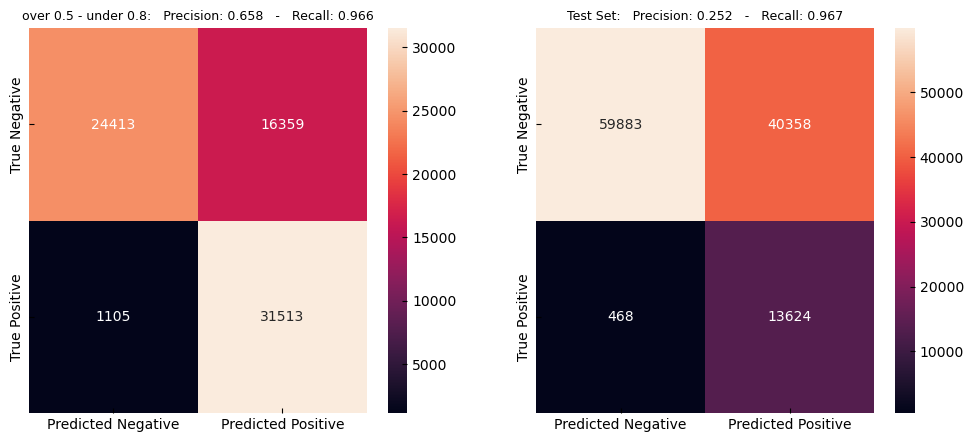

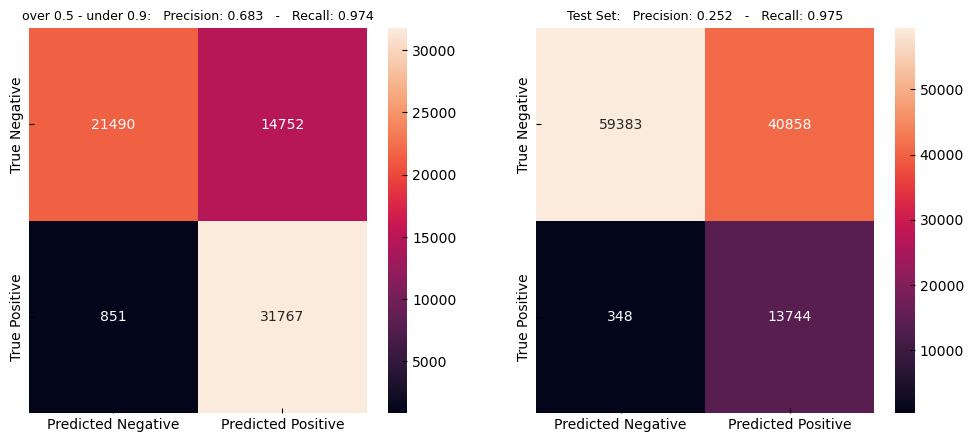

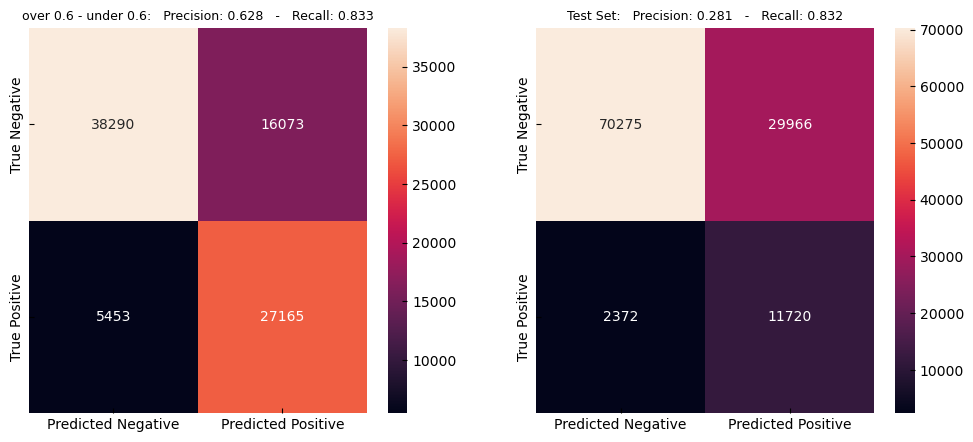

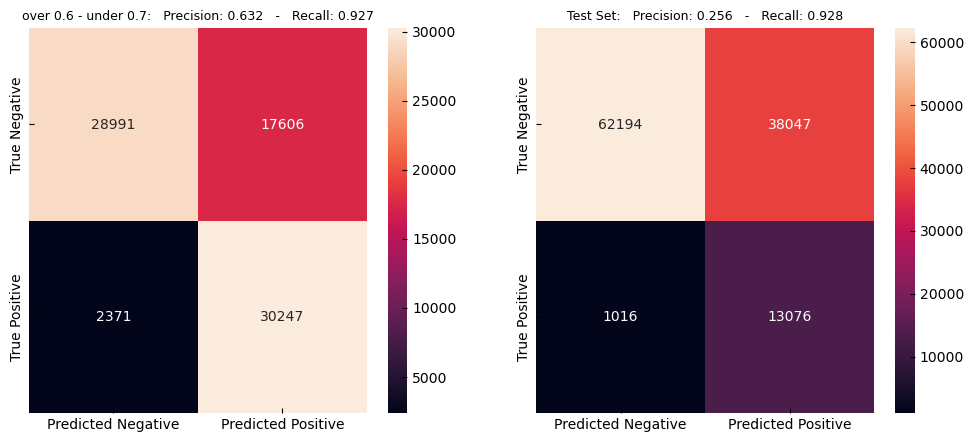

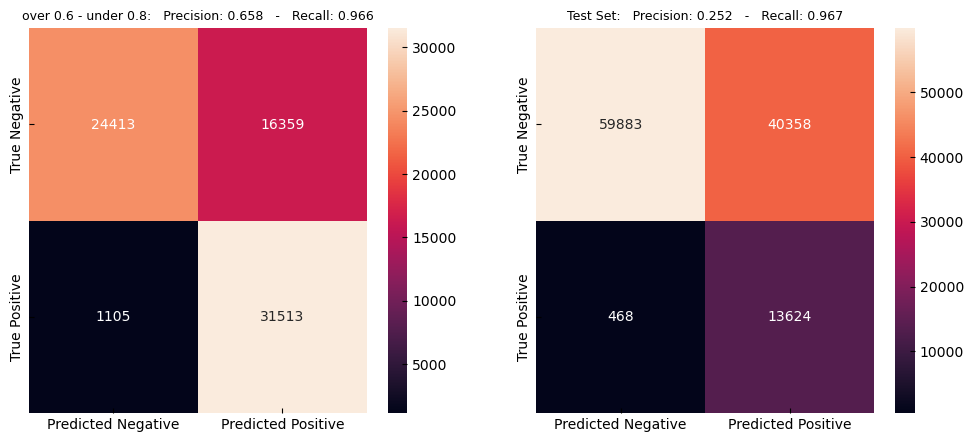

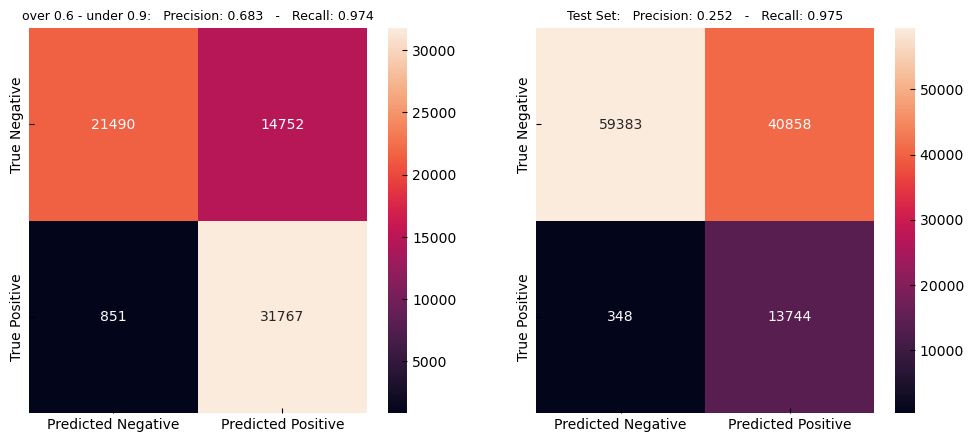

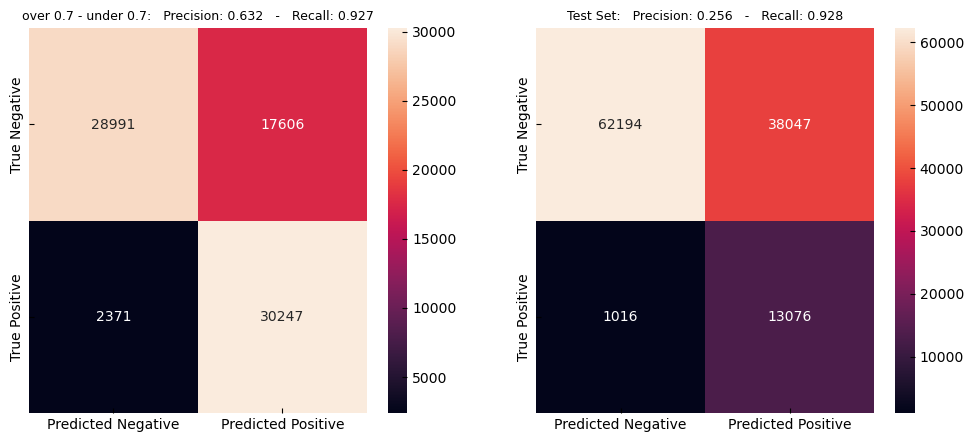

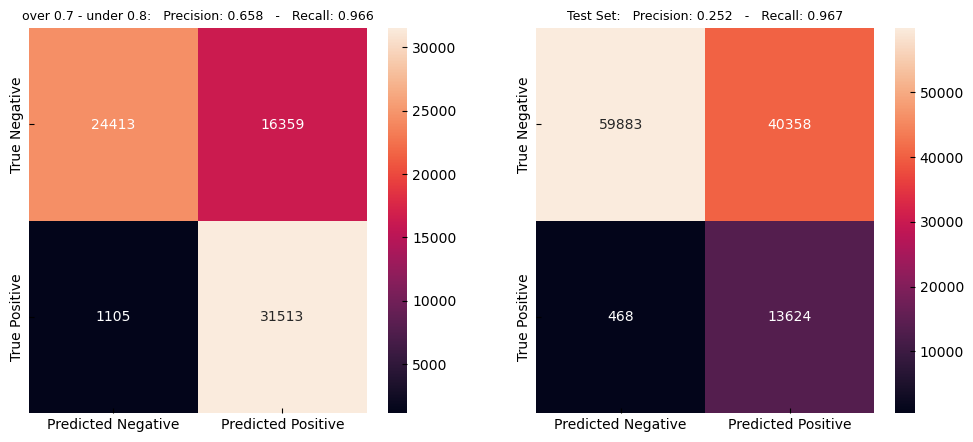

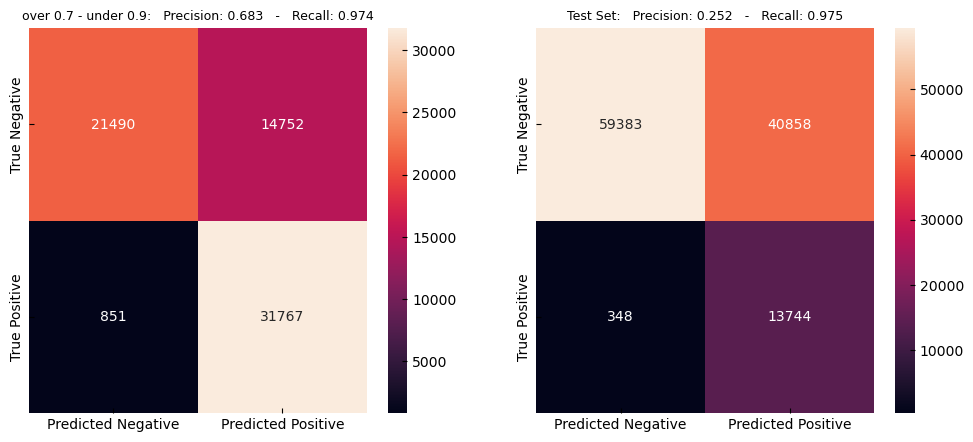

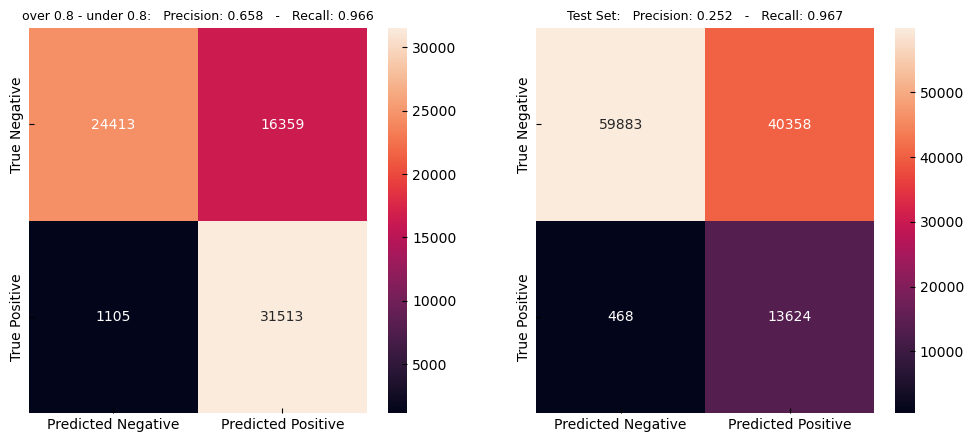

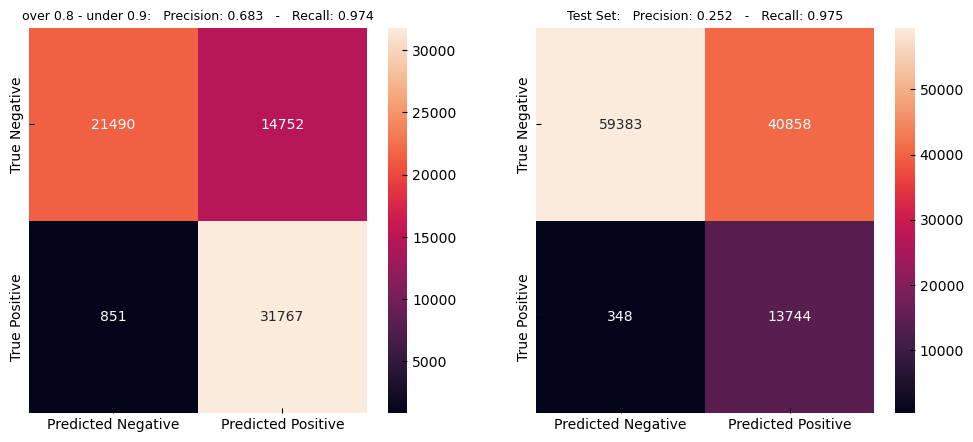

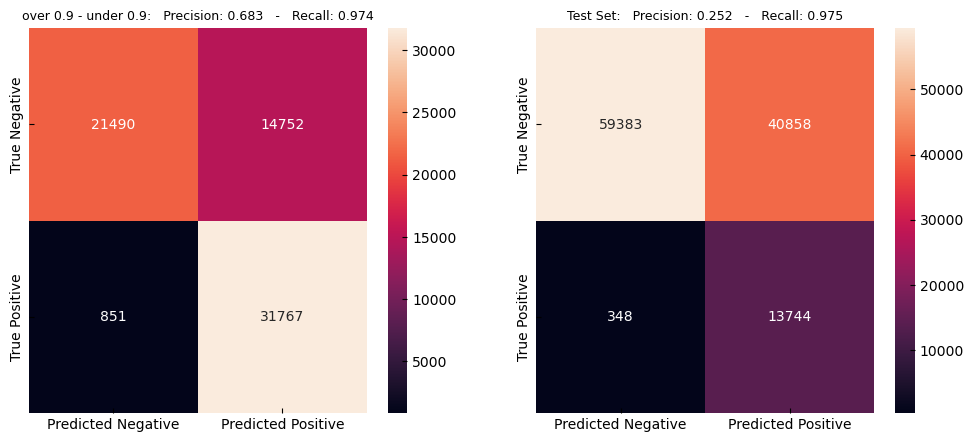

In [162]:

# dataset
X_train = X_TRAIN.copy()
y_train = Y_TRAIN.copy()
X_test = X_TEST.copy()
y_test = Y_TEST.copy()

# numerical/continous feature
cont_features = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

for over in range(2,10):
    #define oversampling strategy
    ros = RandomOverSampler(sampling_strategy=over/10, random_state=RANDOM_SEED)
    for under in range(over,10):
        rus = RandomUnderSampler(sampling_strategy=under/10, random_state=RANDOM_SEED)
            
        # dataset
        X_train = X_TRAIN.copy()
        y_train = Y_TRAIN.copy()
        X_test = X_TEST.copy()
        y_test = Y_TEST.copy()

        # fit_apply resample on ONLY train set
        title=f"over {over/10} - under {under/10}"
        print(title)
        #X_train, y_train = ros.fit_resample(X_train, y_train)
        # info_dataset(X_train,y_train)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        # info_dataset(X_train,y_train)

        # standardizzazione
        ss = StandardScaler()
        X_train[cont_features] = ss.fit_transform(X_train[cont_features])
        X_test[cont_features] = ss.transform(X_test[cont_features])



        # logistic Regr
        lr = LogisticRegression()
        lr.fit(X_train, y_train) 

        # valuto modello
        y_pred_train = lr.predict(X_train)
        y_proba_train = lr.predict_proba(X_train)

        y_pred_test = lr.predict(X_test)
        y_proba_test = lr.predict_proba(X_test)

        print("CLASSIFICATION REPORT-------------------------m(°.°)m")

        print("\n........................................... TRAIN SET")
        print(classification_report(y_train,y_pred_train))

        print("\n............................................ TEST SET")
        print(classification_report(y_test,y_pred_test))

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = title)
        plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set")

### Risultati

Il modello che meglio si adatta al problema è:
`lr = LogisticRegression(class_weight="balanced") `

Questo porta ad un Recall di 0.98



In [191]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

CLASSIFICATION REPORT-------------------------m(°.°)m

........................................... TRAIN SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234158
           1       0.25      0.98      0.40     32618

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776


............................................ TEST SET
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



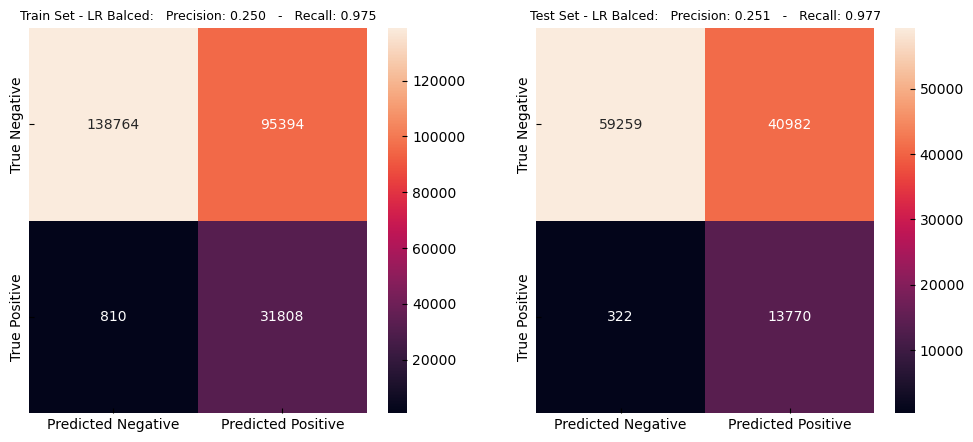

In [200]:
# effettuo copie del dataset originale
X_train = X_TRAIN.copy()
y_train = Y_TRAIN.copy()
X_test = X_TEST.copy()
y_test = Y_TEST.copy()

# standardizzazione delle variabili numeriche/continue
cont_features = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

ss = StandardScaler()
X_train[cont_features] = ss.fit_transform(X_train[cont_features])
X_test[cont_features] = ss.transform(X_test[cont_features])

# logistic regressione con bilanciamento
lr = LogisticRegression(class_weight="balanced" ,random_state=RANDOM_SEED) 
lr.fit(X_train, y_train)

# calcolo le previsioni e le probabilità

y_proba_train = lr.predict_proba(X_train)
y_pred_train = lr.predict(X_train)

y_proba_test = lr.predict_proba(X_test)
y_pred_test = lr.predict(X_test)


print("CLASSIFICATION REPORT-------------------------m(°.°)m")

print("\n........................................... TRAIN SET")
print(classification_report(y_train,y_pred_train))

print("\n............................................ TEST SET")
print(classification_report(y_test,y_pred_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(y_train, y_pred_train, show_precision_recall=True, ax=ax1, title = "Train Set - LR Balced")
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True, ax=ax2, title = "Test Set - LR Balced")



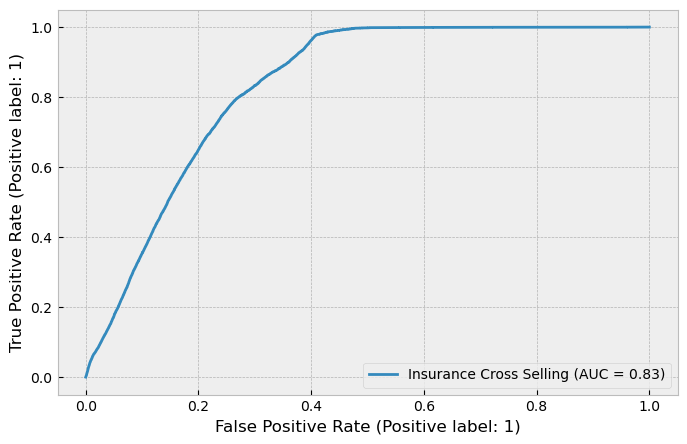

In [202]:
plot_roc_curve(lr, X_test, y_test, name="Insurance Cross Selling")

### Conclusioni

Lo scopo del progetto è qurllo di prevedere le opportunità di cross-selling per un'azienda di assicurazioni. 

Il dataset utilizzato contiene informazioni sui dati demografici, sui veicoli e sulle polizze degli assicurati dell'anno precedente. 
Il dataset di presenta fortemente sbilanciato verso la classe negativa, con un rapporto di circa 1 a 10, ovvero un esito positivo (sottoscrizione del prodotto assicurativ) a fronte di 10 contatti.

L'obbiettivo è aumentare questo rapporto.

Il problema è un problema di classificazione binaria pertanto è stato scelto un modello di Regressione Logistica prestando la dovuta attenzione al ribilanciamento del dataset.

I risultati mostrano un recall del 98%, il che significa che il modello identifica correttamente il 98% dei potenziali acquirenti. Tuttavia, la precision è del 25%, il che indica che solo il 25% dei lead identificati dal modello sono effettivamente validi. 
Questo comporta che solo 1 vendita su 4 potrebbe avere esito positivo.

Questo è un ottimo risultato per una compagnia di assicurazioni!
Adottando questo modello predittivo, la Compagnia sarebbe in grado di raggiundere lo stesso risultato produttivo in meno della metà del tempo, che si traduce in un dimezzamento del costo del lavoro.

Supponiamo di voler raggiungere l'obbiettivo di 1000 contratti, stimando un tempo medio di contatto di 3 minuti (canale telefonico), abbiamo:

|  | numero contatti | tempo (h) | ratio |
|:--| ---------------:|-----------:|:-----:|
|No Modell | 10000 | 500 | 1:10|
|LR Pred. Model | 4000 | 200| 1:4|



#### Limitazioni del Modello

Le limitazioni di questo modello includono il fatto che il dataset originale sia fortemente sbilanciato, il che potrebbe influenzare la performance del modello. 

Inoltre, l'utilizzo di una sola tecnica di modello potrebbe non essere sufficiente per ottenere il massimo della performance. 

Infine, il modello non tiene conto di altri fattori che potrebbero influenzare la decisione di acquistare un'assicurazione per il veicolo, come ad esempio la situazione economica del cliente o la qualità del servizio offerto dall'azienda di assicurazioni.